# Training Spacy's Named Entity Recognizer (NER)

In this document, we train Spacy's medium Spanish NER model on our own documents to improve results for Early Modern texts, with the possibility of adding new labels. 

## Why train?

Spacy's statistical models are trained on different corpora, often specific genres like news or Wikipedia articles.  The structures of these genres may not map onto those of historical texts. Historical archival texts display differences with modern text in spelling and grammatical structure. They are also relatively standardized, meaning that training on your own data can improve accuracy for existing tags. We can also train the model to recognize new tags.

An alternative to improving an existent model is to train your own from scratch, but this necessitates much larger amounts of data. Whereas Spacy recommends a few hundred to a few thousand examples for updating an existing model, you might need up to a million to train a new one. 

# Necessary Inputs

To train a preexisting model, we need the model you want to work with and a corpus of tagged texts that will be divided into training and test data. 

### A Pretrained Spacy Model

First, we load the model that we are interested in using, here the [Spanish medium-sized model](https://spacy.io/models/es). 

In [1]:
#We import modules to be used in this session

#For training
from __future__ import unicode_literals, print_function

import plac
import random
from pathlib import Path

import spacy
from spacy.util import minibatch, compounding
from spacy.lang.es import Spanish 
from spacy import displacy

from sklearn.model_selection import train_test_split

#For evaluation
from spacy.scorer import Scorer
from spacy.language import GoldParse

import json

In [2]:
#We load the Spacy Model to be trained

nlp = spacy.load('es_core_news_md')

To illustrate how the model performs out-of-the-box, we upload a short text, process it with the Spanish model (resulting in a 'doc' object) and view the Named Entity Recognition results.

In [3]:
#Process a single text.

doc1=nlp("antonio de alfian pintor vezino de esta cibdad de seuilla en la collacion de la madalena otorgo e conozco que doy todo mi poder a francisco de arfian mi hijo especialmente para que por mi pueda pedir de alonso de la milla clerigo mayordomo de la fabrica de la iglesia de santa maria de la villa de carmona sesenta e cinco ducados que me a de pagar por virtud de un mandamiento del señor provisor")

#View out-of-the-box NLP results with displacy

displacy.render(doc1, style="ent", jupyter=True)


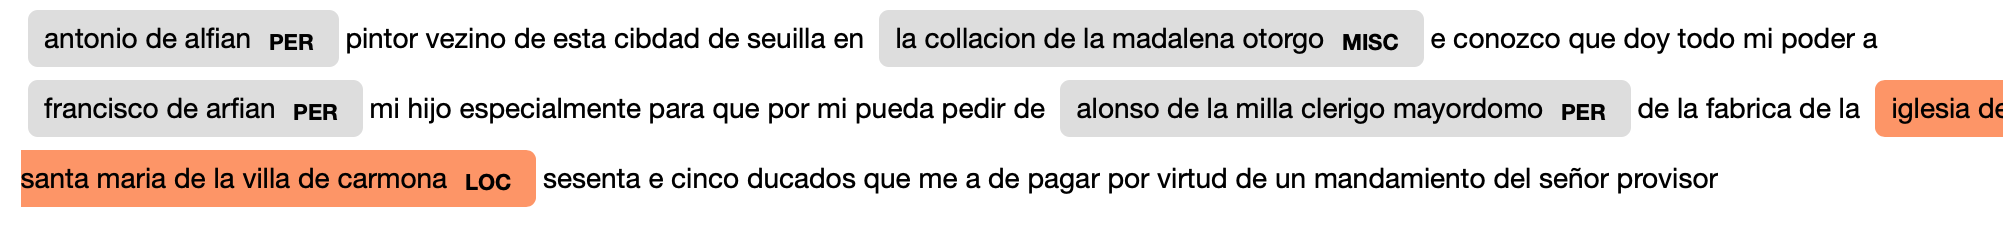

(This is an image of what the results should look like, because they won't render on GitHub. If you download the document and run the code, it should display as above).

In [4]:
#Alternatively, we can create a list of entities with labels:
print("Entities in '%s'" % doc1)
for ent in doc1.ents:
    print(ent.label_, ent.text)

Entities in 'antonio de alfian pintor vezino de esta cibdad de seuilla en la collacion de la madalena otorgo e conozco que doy todo mi poder a francisco de arfian mi hijo especialmente para que por mi pueda pedir de alonso de la milla clerigo mayordomo de la fabrica de la iglesia de santa maria de la villa de carmona sesenta e cinco ducados que me a de pagar por virtud de un mandamiento del señor provisor'
PER antonio de alfian
MISC la collacion de la madalena otorgo
PER francisco de arfian
PER alonso de la milla clerigo mayordomo
LOC iglesia de santa maria de la villa de carmona


As we can see, the model already does some good work, but there are several mistakes. The third PER (person) tag  picks up the name of the individual, but also some irrelevant titles. The LOC tag picks up a church within a city, which we would prefer to have as an ORG, and it missed the twelfth token, the city of Seville (seuilla) as an entity. We would thus like to improve the accuracy of these preexisting tags.

Additionally, there are new tags we would like to add to the preexisting model. For instance, in this text there is a monetary quantity (sesenta e cinco ducados) that we would like the model to identify. The Spacy medium Spanish model includes tags for PER (person), LOC (location), ORG (organization) and MISC (miscellaneous) entities. We will add MON (monetary), DATE and OBJ (object) tags.

### Training and Test Data

Training necessitates annotated data for the training of the model itself and later evaluation. For NER, this means a set of texts with correctly labeled entities. This is largely a manual process, made easier by softwares designed for data tagging. [Prodigy](https://prodi.gy) is Spacy's own software, but open-access alternatives are also available ([Dataturks](http://dataturks.com), [Brat](http://brat.nlplab.org), [Tagtog](http://tagtog.net)). 

The correct tagging of data requires some thought, as the edges of entities are often unclear. We used a few guiding criteria. We asked: if this were the model's output, would we be happy with the result? We made entities as short as possible, and tagged related entities separately (their relationships to be modeled after). Tags could not overlap (taking special care in Dataturks, because their automated selection of similar words, though helpful overall, often causes this issue). 

We have used [Dataturks](https://dataturks.com) for elaborating our own training data (downloadable here). It is open-source and results in a format easily importable into Spacy. To speed the tagging process, we first ran the Spacy model on our untagged texts, generating a prior annotated version (with many errors) that we uploaded onto Dataturks (instructions [here](https://github.com/FelipeAdeT/ArtMarketsofSeville/blob/master/Notebooks/Preparing%20a%20Text%20File%20for%20DataTurks.ipynb)). We then edited the tags on that website and exported the file. Dataturks produces a file in a slightly different format than Spacy, but they provide a function for converting between formats (we have done this in a different notebook, available [here](https://github.com/FelipeAdeT/ArtMarketsofSeville/blob/master/Notebooks/Converting%20Dataturks%20Tagged%20Texts%20to%20Spacy%20Format.ipynb)).

In [3]:
# Read Tagged Data from JSON file
with open('TaggedData_SF.json', 'r', encoding='utf-8') as fp2:
    TAGGED_DATA = json.load(fp2)

 First, we can more formally measure how well the model was performing without any re-training.

# Evaluating Out-of-the-Box Results

Spacy has a built-in function for evaluating a model's performance using the [command line](https://spacy.io/api/cli#evaluate), but alternatively you can define a function like the one below. It takes the NER model and examples that you input and returns several metrics:
        - UAS (Unlabelled Attachment Score) 
        - LAS (Labelled Attachment Score)
        - ents_p
        - ents_r
        - ents_f
        - tags_acc
        - token_acc

[According](https://github.com/explosion/spaCy/issues/2405) to one of the creators of Spacy, 
>The UAS and LAS are standard metrics to evaluate dependency parsing. UAS is the proportion of tokens whose head has been correctly assigned, LAS is the proportion of tokens whose head has been correctly assigned with the right dependency label (subject, object, etc).
>ents_p, ents_r, ents_f are the precision, recall and fscore for the NER task.
>tags_acc is the POS tagging accuracy.
>token_acc seems to be the precision for token segmentation.

The key metrics for this task are the precision, recall and f-score.
**Precision** (ents_p) is the ratio of correctly-labeled entities out of all the entities labeled. (True Positive/(True Positive+False Positive)).
**Recall**  (ents_r) is the ratio of correctly-labeled entities out of all true entities (True Positive/(True Positive+False Negative)). The F-score is the mean of both values.  

These metrics all appear averaged out through all the entity types (labels) and then detailed for each label in particular. We want these values to be as close as possible to 100. 


In [4]:
#Defining the evaluation function

def evaluate(ner_model, examples):
    scorer = Scorer()
    for sents, ents in examples:
        doc_gold = ner_model.make_doc(sents)
        gold = GoldParse(doc_gold, entities=ents['entities'])
        pred_value = ner_model(sents)
        scorer.score(pred_value, gold)
    return scorer.scores

In [5]:
#Applying the evaluation function to pre-trained model with all our tagged data

results = evaluate(nlp,TAGGED_DATA)
print(results)

{'uas': 0.0, 'las': 0.0, 'ents_p': 46.5510881593508, 'ents_r': 42.24974891195179, 'ents_f': 44.296244296244296, 'ents_per_type': {'LOC': {'p': 41.92439862542955, 'r': 47.71838331160365, 'f': 44.634146341463406}, 'ORG': {'p': 8.695652173913043, 'r': 1.5037593984962405, 'f': 2.564102564102564}, 'PER': {'p': 54.290931223371885, 'r': 75.91489361702128, 'f': 63.307310149041875}, 'MON': {'p': 0.0, 'r': 0.0, 'f': 0.0}, 'OBJ': {'p': 0.0, 'r': 0.0, 'f': 0.0}, 'MISC': {'p': 0.0, 'r': 0.0, 'f': 0.0}, 'DATE': {'p': 0.0, 'r': 0.0, 'f': 0.0}}, 'tags_acc': 0.0, 'token_acc': 100.0, 'textcat_score': 0.0, 'textcats_per_cat': {}}


As we can see, the overall precision, recall and f-score are low (in the 40s), but this is largely due to the fact that we have tags for labels that don't yet exist in the model (for all these new labels, the model scores 0 on all these measures). For existing labels, we see that results vary, but can be improved. 

# Training the Model

As said before, we will need some data for training and some for evaluation. Typically, an 80-20 split is a good choice (80% training data, 20% test data).  

We first calculate just how many data points we need for training, based on the size of our tagged sample. Then we randomly split our tagged data proportionally into train_data and test_data.

In [6]:
#Calculate 80% of tagged data for division into training and testing data

print(len(TAGGED_DATA)*0.8)

326.40000000000003


In [4]:
# Batching the Tagged Data into training and evaluation data (80-20)

random.shuffle(TAGGED_DATA)
train_data = TAGGED_DATA[:326]
test_data = TAGGED_DATA[326:]

Next comes the training process. Spacy provides a way to train the model via the [command line](https://spacy.io/usage/training#spacy-train-cli), but we will build the training loop manually. 

In [5]:
#Create object for retrieving the NER pipeline component
ner=nlp.get_pipe("ner")

#Generate new labels for the NER component (if you wish to create new labels)
ner.add_label("OBJ")
ner.add_label("MON")
ner.add_label("DATE")

#This piece of code creates a loop in which we train the model, but only for the NER component (disabling the tagger and the parser, which we are not using here).
with nlp.disable_pipes('tagger','parser'):
#Here we resume training, alternatively you could begin_training if you are starting on a new model.
    optimizer= nlp.resume_training()
#Sizes for the minibatching
    sizes = compounding(1.0, 4.0, 1.001)
#This loops the training mechanism 10 times, randomly shuffling the training data and creating mini-batches from which the algorithm learns to label. Each time a batch is processed, the model is updated.
    for itn in range(10):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=sizes)
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)
            print("Losses", losses)

Losses {'ner': 29215.165053071694}
Losses {'ner': 27128.040782005246}
Losses {'ner': 26671.43876299599}
Losses {'ner': 26628.9134316227}
Losses {'ner': 26373.89165395056}
Losses {'ner': 26706.879815614782}
Losses {'ner': 26406.34644309478}
Losses {'ner': 26108.571956321597}
Losses {'ner': 26526.65727315098}
Losses {'ner': 26412.8836187087}


# Saving the Updated Model

Training the model is that simple. If you want to use the updated model in the future, you will want to save it to a directory you have created beforehand. 

In [6]:
#First, let's change the model's metadata to reflect that it is a new model that has been trained. It will allow us to recall it independently from the old one in future uses.
nlp.meta['name']='core_news_ml_EMS'

In [11]:
#Save trained model to disk for later reuse

nlp.to_disk("Trained_ModelEMS")

Spacy recommends that you package the model, making it easier to employ after. This must be done on the command line. First, call the directory your model is in. Then, following the lines of code below:

Create the directory in which your packaged model will go.

Spacy's package command creates a model package directory.

Call the directory in which the .tar file will be stored.

Build the package, creating a .tar.gz file in the directory /dist.

Install the model by pointing pip to the file path.

```mkdir PackagedModel
python -m spacy package Trained_ModelEMS PackagedModel
cd PackagedModel/es_core_news_ml_EMS-2.2.0/
python setup.py sdist
cd dist/
pip install es_core_news_ml_EMS-2.2.0.tar.gz
```

Next time you use spacy, you will be able to call the updated model by using the **spacy.load()** command with the model name.


# Evaluating the Trained Model

Now that the model has been updated, you can check how much it has improved. Visually, using our previous example, we can see that the tagging has improved dramatically on preexisting and new labels:

In [4]:
doc2=nlp("antonio de alfian pintor vezino de esta cibdad de seuilla en la collacion de la madalena otorgo e conozco que doy todo mi poder a francisco de arfian mi hijo especialmente para que por mi pueda pedir de alonso de la milla clerigo mayordomo de la fabrica de la iglesia de santa maria de la villa de carmona sesenta e cinco ducados que me a de pagar por virtud de un mandamiento del señor provisor")

#View out-of-the-box NLP results with displacy

displacy.render(doc2, style="ent", jupyter=True)

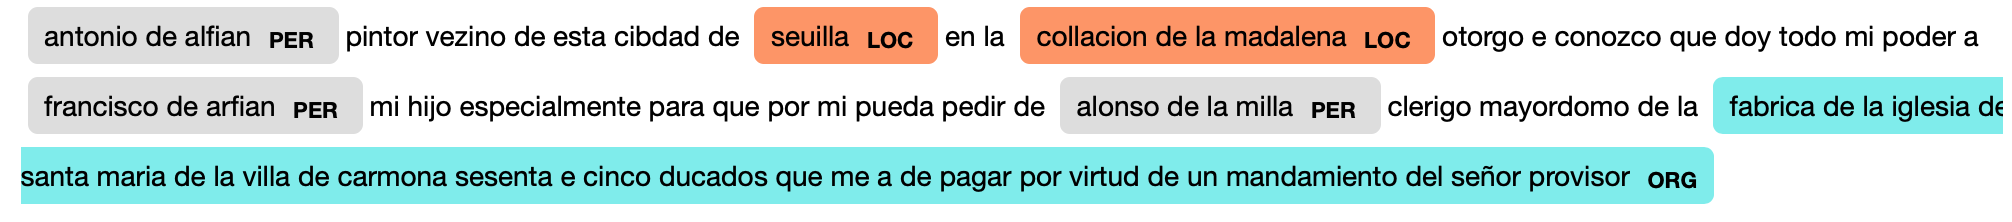

We can more formally measure this by using the test_data with the evaluate function.

In [14]:
#Evaluate trained model on test/evaluation data

results2 = evaluate(nlp,test_data)
print(results2)

{'uas': 0.0, 'las': 0.0, 'ents_p': 83.4368530020704, 'ents_r': 65.84967320261438, 'ents_f': 73.60730593607305, 'ents_per_type': {'MON': {'p': 73.33333333333333, 'r': 72.1311475409836, 'f': 72.72727272727273}, 'PER': {'p': 87.76371308016878, 'r': 91.62995594713657, 'f': 89.65517241379311}, 'OBJ': {'p': 100.0, 'r': 2.197802197802198, 'f': 4.301075268817205}, 'LOC': {'p': 85.53459119496856, 'r': 80.95238095238095, 'f': 83.18042813455658}, 'ORG': {'p': 50.0, 'r': 20.0, 'f': 28.571428571428577}, 'DATE': {'p': 66.66666666666666, 'r': 20.0, 'f': 30.769230769230766}}, 'tags_acc': 0.0, 'token_acc': 100.0, 'textcat_score': 0.0, 'textcats_per_cat': {}}


As can be seen, the results have improved greatly for preexisting labels (PER, ORG, LOC) and have improved for the new labels (DATE, MON, OBJ). 

The extent to which you can improve your model will depend on several parameters, including the quantity and quality of training data. It is worth noting that the measurements above will to some extent depend on the ways the data was shuffled; so one iteration may perform better or worse depending on which texts were taken as training data. We have created other notebooks in which you can run several trials and develop an idea of the average values of these indicators and their variance. 

It is also worth noting that texts can have different characteristics that will affect the performance of the model. As previously stated, models are often trained on modern texts of very defined genres, like news or wikipedia articles. Spelling variation, differences in tokenization or differences in sentence fragmentation could affect model performance. This is especially true of historical documents and those taken from social media. Normalizing your own documents could improve performance. We have another document that helps you include a normalization dictionary in your pipeline before training, and similar adaptations could be made to the tokenizer and sentence fragmenter.

Because NER will not provide perfect results, it could be useful to be able to read through all documents with their labels. You can do this with the script below:

In [1]:
#To visualize predicted entities in all documents:

#df = pd.read_csv('~/Documents/Research/NLP/SevillianPaintersNLP/DocumentsTest.txt', delimiter =",")
#docs = list(nlp1.pipe(df['document']))
#for doc in docs:
#    displacy.render(doc, style="ent", jupyter=True)
#    print("---")